## Investigation on the Thomas Fire Impacts in Santa Barbara County, CA (2017 - 2018)

##### Author: Sofia Ingersoll

##### Published: 2023-12-12

### 🗃️GitHub Repo: https://github.com/saingersoll/Thomas_Fire_Investigation
<div>
<img src="ThomasFireGE_12-13-2017.png" width="600" height="200"/>
</div>

Google earth V 6.2.2.6613. (December 13, 2017). Santa Barbara, United States.
34.6099° N, 120.0665° W, Eye alt 13.72 feet.
DigitalGlobe 2020. http://www.earth.google.com [December 12, 2023]. 

### The Thomas Fire
On December 4, 2017, the [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County.  began to sweep throughout Ventura and Santa Barbara County, CA. For 40 days, a devistating total of 281,893 acres were consumed; destroying 1,063 structures and claiming two casualties (one civilian and one firefighter). Investigations have found that this wildfire was the result of a "line slap," shared between Southern California Edison ("SCE") powerlines during a high wind event that sparked hot materials to ignite a nearby fuel bed [(Ventura County Fire Department)](https://vcfd.org/news/vcfd-determines-cause-of-the-thomas-fire/). As of 2019, SCE agreed to a $360 million settlement to address the conglomorate negative impacts caused by the Thomas Fire, Woolsey Fire, and Koeningstein Fire. As well as, the ripple effect of the Thomas Fire, which was especially felt by community members in January of 2018 when 23 lives were claimed from a debris flow in Montecito [(Wildfire Today, ](https://wildfiretoday.com/tag/thomas-fire/) [California Govenor's Office of Emergency Services)](https://news.caloes.ca.gov/montecito-mudslides-anniversary-reflections-through-images/).

### Objective 
To get a better understanding of the initial environmental and public health impacts caused by the Thomas Fire, together, we will explore the Air Quality Index (AQI) of SB County between 2017/01 - 2018/10. We'll quanitfy and visualize the amount of particulate matter seen in the image abouve using both the Daily AQI and the average AQI over a 5 day rolling window in units of ppm. In addition, we will gain insight into what parts of Santa Barbara County were exposed to the Thomas Fire, through the examination of burn scars using false-color imaging on Landsat 8 satellite data from the Microsoft Planetary Computer ("MPC"). We will use a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data. 

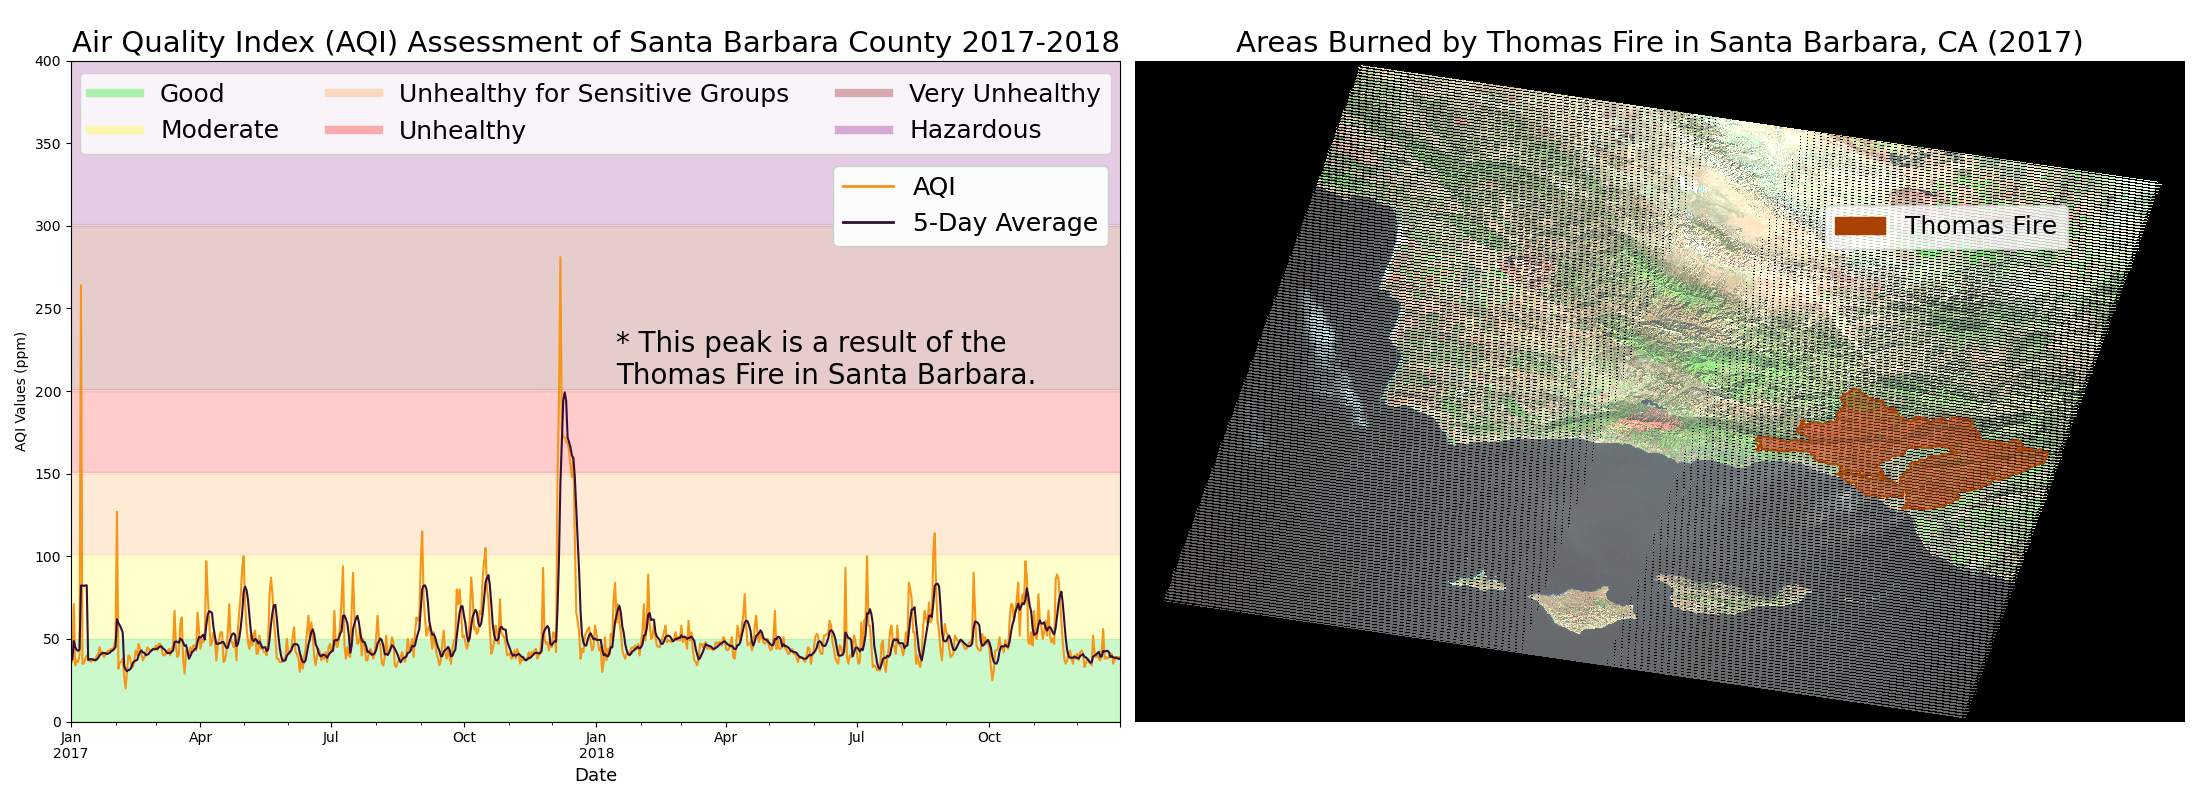

### Techniques Applied

* Directly accessing & processing [MPC STAC data](https://planetarycomputer.microsoft.com/catalog) 
* Raster analysis applying false color imagery
* Time series analysis

### Data Access

#### `AQI Data for PPM Quantification & Trend Analysis Overtime`

The [Daily Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data to quantify the particulate matter released into Santa Barbara County from the fire was collected here from the [US Environmental Protection Agency](https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI) to visualize the rolling AQI averages between 2017 and 2018.


#### `Landsat Data for Burn Scar Visualization`

For our true and false color imagery, we are going to direct access [Microsoft Planetary Computer Landsat Collection 2 Level-2 data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). The STAC item utilized for this project is ****LE07_L2SP_042036_20171217_02_T1****. The raster data was collected on 2017-12-17.

*This data should be used for visualization purposes only.*

#### `California Fire Perimeter Data for Burn Scar Visualization`

The shapefile of fire perimeters in California were provided by the California State Geoportal. The [complete file can be accessed here](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

#### Data References

* US Environmental Protection Agency (2023). Daily AQI by County [Data File]. Available from https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed October 25, 2023

* Microsoft Planetary Computer. Landsat Collection 2 Level-2 [Dataset]. Available from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed November 28, 2023

* California Department of Forestry and Fire Protection (2023). California Fire Perimeters (all) [Data File]. Available from https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed November 28, 2023

### Software Specifications

In [11]:
#------------------------------------
# ----    Load the Essentials    ----
#------------------------------------
# Reading in libraries and functions
import os
import warnings
import numpy as np
import pandas as pd

import pystac
import planetary_computer

import rasterio
import xarray as xr
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

### Read & Wrangle SB County AQI Data

To simplify our workflow, we're going to combine the 2017 and 2018 data sets, and wrangle a single concatonated dataset.

Once we have one dataset, we will select our region of interest (ROI) and correct the Date `dtype` so it may be used as the `index` to calculate the average Air Quality Index over a 5 day rolling window.

In [12]:
#------------------------------------
# ----       Read & Wrangle      ----
#------------------------------------
# Reading in the data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')                     
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip') 

# glueing the datasets together
aqi = pd.concat([aqi_17, aqi_18])                                                                         
#  .str.replace(' ','_') to replace the space for _
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')     

# Subsetting using loc
# selecting SB county
aqi_sb = aqi.loc[aqi.county_name == 'Santa Barbara']   
# isolating desired columns   
aqi_sb = aqi_sb.iloc[:, 4:]                               

#  Datetime Indexing
# converting the date type to datetimes64
aqi_sb.date = pd.to_datetime(aqi_sb.date)    
 # updating the index to the data column                       
aqi_sb = aqi_sb.set_index('date')                                    

# Rolling Window Mean Calc
# provides rolling window calculations of 
# the mean aqi over 5 day periods  
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()         

##### Check-point
Is everything looking as we expect it to?

In [13]:
#------------------------------------
# ----        Check Point!       ----
#------------------------------------
# checking that dataframes joined properly and column names changed
print('The number of aqi observations in 2017 were:', len(aqi_17.Date))
print('The number of aqi observations in 2018 were:', len(aqi_18.Date))
print('The number of aqi observations between 2017-2018 were:', len(aqi.date))        

The number of aqi observations in 2017 were: 326801
The number of aqi observations in 2018 were: 327537
The number of aqi observations between 2017-2018 were: 654338


### AQI Visualization: Scatter Plot of 5 Day Average AQI Assessment, Santa Barbara County (Jan 2017 - Oct 2018)

The visual below displays the mean AQI over a 5 day rolling window between January 2017 and October 2018. A spike in air pollutants between the months of December 2017 and January 2018 is clearly observed, indicating negative effects on air quality resulting from the Thomas Fire.

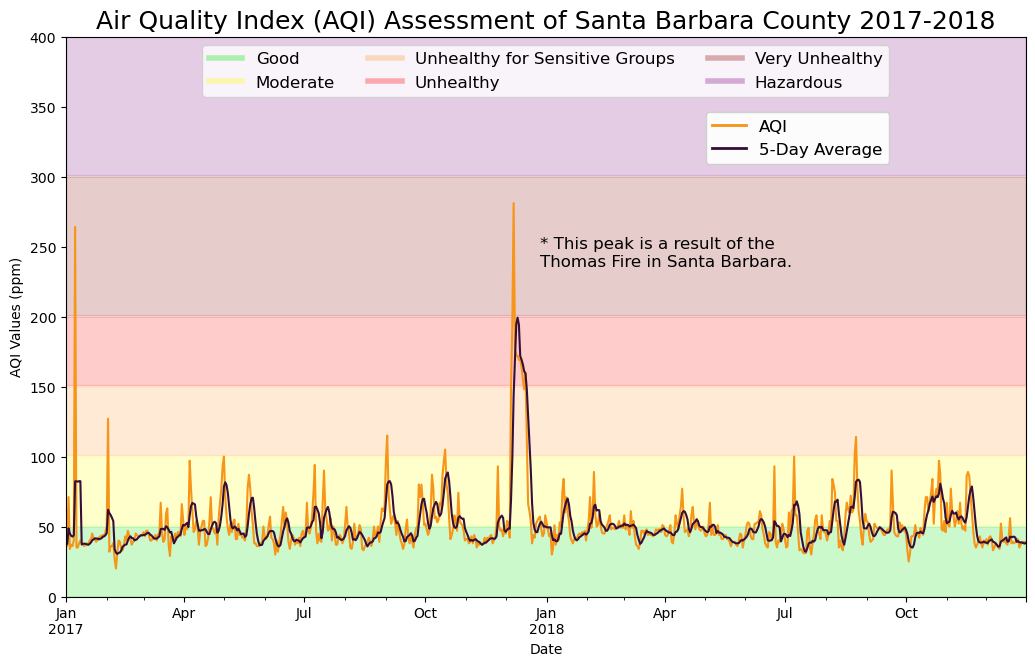

In [14]:
#------------------------------------
#  ----     Customization        ----
#------------------------------------
# Define AQI categories and colors
aqi_categories = {
    'Good': (0, 50, '#00E400'),
    'Moderate': (51, 100, '#FFFF00'),
    'Unhealthy for Sensitive Groups': (101, 150, '#FF9933'),
    'Unhealthy': (151, 200, '#FF0000'),
    'Very Unhealthy': (201, 300, '#8B0000'),
    'Hazardous': (301, 500, '#800080')
}

colors = {'aqi':'#f69517',
          'five_day_average':'#360F39'}


#------------------------------------
#  ----     Visualizing AQI      ----
#------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot AQI categories as background colors for associated ranges
for category, (lower, upper, color) in aqi_categories.items():
    ax.fill_between(aqi_sb.index, lower, upper, color=color,
                    alpha=0.2,
                    label=f'{category}')

# Plot the AQI and 5-Day Rolling Average
aqi_sb.plot(ax=ax,
            y=['aqi', 'five_day_average'],
            color=colors,
            xlabel='Date',                                                   
            ylabel='AQI Values (ppm)',
            ylim= (0,400),
            legend= True
            )

# applying customizations
ax.set_title('Air Quality Index (AQI) Assessment of Santa Barbara County 2017-2018', 
             fontsize=18) 

# Add a legend for background colors
background_legend = [Line2D([0], [0], color='#00E400', lw=4, alpha=0.3),
                     Line2D([0], [0], color='#FFFF00', lw=4, alpha=0.3),
                     Line2D([0], [0], color='#FF9933', lw=4, alpha=0.3),
                     Line2D([0], [0], color='#FF0000', lw=4, alpha=0.3),
                     Line2D([0], [0], color='#8B0000', lw=4, alpha=0.3),
                     Line2D([0], [0], color='#800080', lw=4, alpha=0.3)]

# Add background color legend to the plot
background_legend_art = ax.legend(handles=background_legend,
                                  labels=['Good', 'Moderate',
                                          'Unhealthy for Sensitive Groups',
                                          'Unhealthy', 'Very Unhealthy',
                                          'Hazardous'],
                                  loc='upper center',
                                  bbox_to_anchor=(0.5, 1),
                                  ncol=3,
                                  fontsize = 12)
# Line color legend
line_legend = [Line2D([0], [0], color='#f69517', lw=2),
               Line2D([0], [0], color='#360F39', lw=2)]

# Add line color legend to the plot
line_legend_art = ax.legend(handles=line_legend,
                            labels=['AQI', '5-Day Average'],
                            loc='upper right',
                            bbox_to_anchor=(0.866, 0.88),
                            fontsize = 12)

# Add both legends to the plot
ax.add_artist(background_legend_art)
ax.add_artist(line_legend_art)

# Add annotation
ax.annotate("* This peak is a result of the \nThomas Fire in Santa Barbara.", 
            xy=(0.45, 0.5), # position
            xycoords='figure fraction', 
            fontsize=12, 
            color='black') 

# Adjust subplot parameters to add margin space
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.9)

plt.show()

### Read & Inspect Burn Scar Data

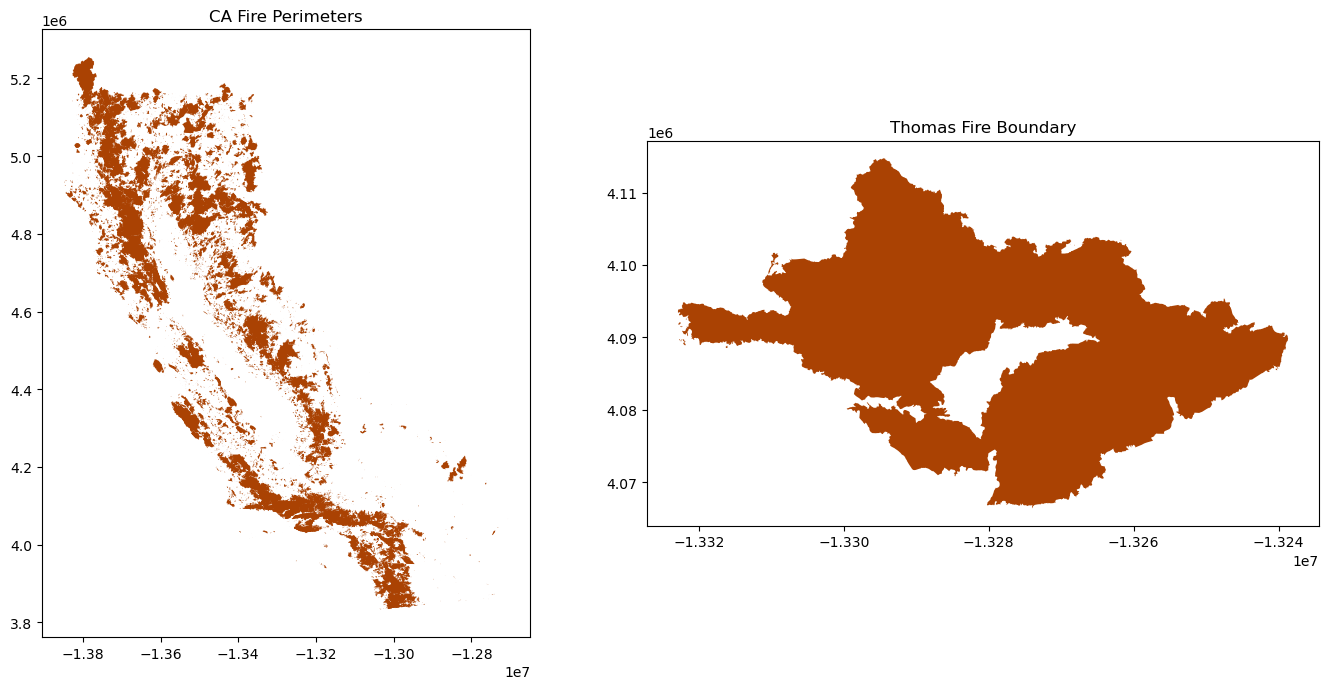

In [15]:
#------------------------------------
# ----        Read  & Inspect     ----
#------------------------------------
# Reading in the data for CA fire perimeters 
ca_fire = gpd.read_file(os.path.join(os.getcwd(),'..','data','California_Fire_Perimeters_1379327890478655659','California_Fire_Perimeters_(all).shp'))

#------------------------------------
# ----        Check Point!       ----
#------------------------------------
# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning) 

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# quick viuslaization of CA fire perimeters
# yow-za! CA is so clearly shaped }:<
ca_fire.plot(ax = ax[0],
             color = '#AA4203')
ax[0].set_title('CA Fire Perimeters')


# Subset for Thomas Fire boundary data for plotting
thomas_fire = ca_fire.loc[(ca_fire['FIRE_NAME'] == 'THOMAS') & (ca_fire['YEAR_'] >= 2017)]          


thomas_fire.plot(ax = ax[1],
                 color = '#AA4203')
ax[1].set_title('Thomas Fire Boundary')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### MPC Landsat Collection 2 Level-2

Together, we're going to load in Landsat data directly from the Microsoft Planetary Computer STAC and collect our desired bands (SWIR22, NIR08, Red) to create a landsat array subset.`LE07_L2SP_042036_20171217_02_T1` was captured on 12/17/2017 18:36:51 UTC and will be leveraged for this project.

In order to create a false color image, we need to adjust the dimensions of our data to only consider x and y coordinates. Furthermore, we will need to create an array containing the false color bands we intend on utilizing for our ROI. We'll also be correcting the CRS so we can overlay the two datasets.

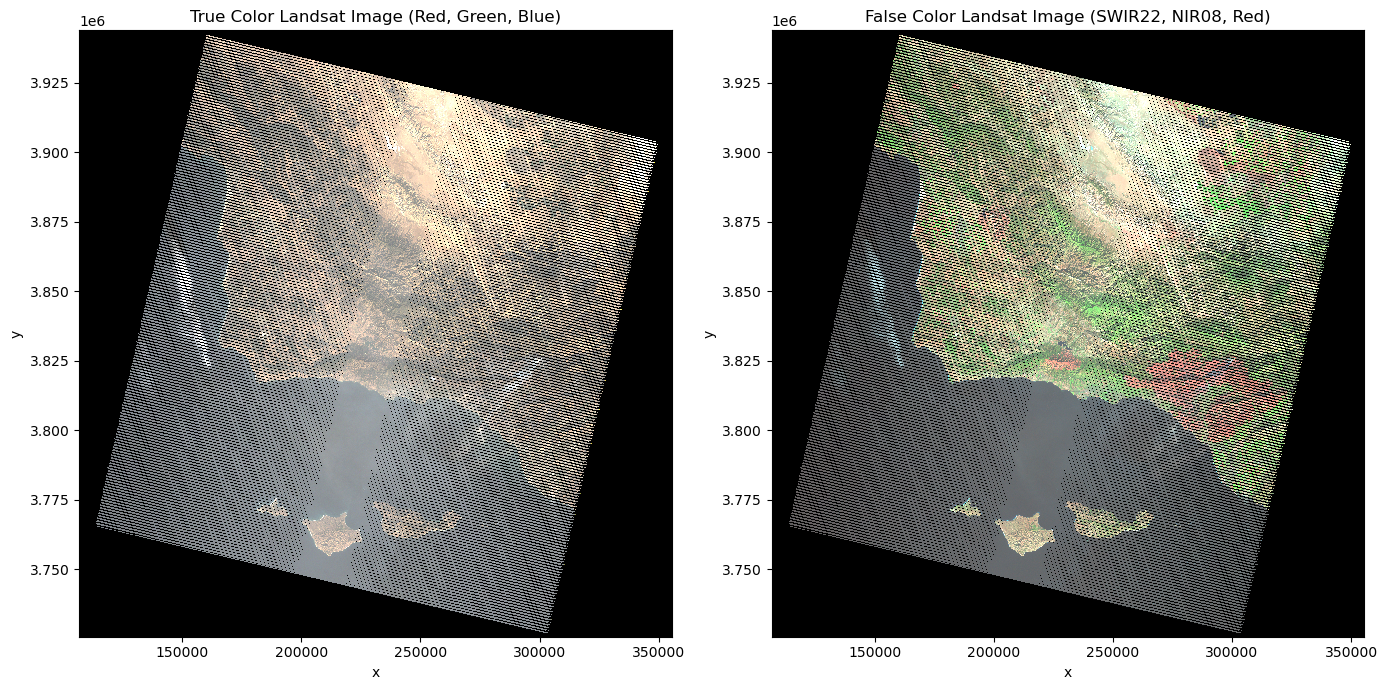

In [16]:
#--------------------------------------
# ---- Pull directly from MPC STAC ----
#--------------------------------------
# Suppress warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Suppress FutureWarnings


# Let's pull our data fresh from the MPC STAC
# We're also going to assign the bands we're interested in
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LE07_L2SP_042036_20171217_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

#--------------------------------------
# ----   Collect band information  ----
#--------------------------------------
# Open the desired data assets
# Short Wave Infrared (SWIR22) band
asset_href_swir22 = signed_item.assets["swir22"].href
landsat_swir22 = rioxr.open_rasterio(asset_href_swir22)

# Near Infrared (NIR08) band
asset_href_nir08 = signed_item.assets["nir08"].href
landsat_nir08 = rioxr.open_rasterio(asset_href_nir08)

# Red band
asset_href_red = signed_item.assets["red"].href
landsat_red = rioxr.open_rasterio(asset_href_red)

# Green band
asset_href_green = signed_item.assets["green"].href
landsat_green = rioxr.open_rasterio(asset_href_green)

# Blue band
asset_href_blue = signed_item.assets["blue"].href
landsat_blue = rioxr.open_rasterio(asset_href_blue)

#--------------------------------------
#  ----  Combine band information  ---- 
#--------------------------------------
#--------------------------------------
#  ----         True Color         ---- 
#--------------------------------------
# Stack bands into a single dataset
true_color = xr.concat([landsat_red, landsat_green, landsat_blue], dim='band')

# Updating data for plotting
# Original dimensions and coordinates show us that band is a dimension
# Remove length 1 dimension (band)
true_color = true_color.squeeze()

# remove coordinates associated to band
true_color = true_color.drop('band')

#--------------------------------------
#  ----        False Color         ---- 
#--------------------------------------
# Note: For false-color, typically, you might use 
# a different combination (like NIR, Red, Green).
# Adjust this based on the specific visualization you want.
false_color = xr.concat([landsat_swir22, landsat_nir08, landsat_red], dim='band')

# Updating data for plotting
# Original dimensions and coordinates show us that band is a dimension
# Remove length 1 dimension (band)
false_color = false_color.squeeze()

# remove coordinates associated to band
false_color = false_color.drop('band')

#--------------------------------------
#  ---- Visualize band information ---- 
#--------------------------------------
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot the true and false color images
#--------------------------------------
#  ----     True Color Image       ---- 
#--------------------------------------
# Plot the false color image
true_color.plot.imshow(ax=ax[0],
                        robust=True) 
ax[0].set_title('True Color Landsat Image (Red, Green, Blue)')


#--------------------------------------
#          False Color Image
#--------------------------------------
false_color.plot.imshow(ax=ax[1],
                        robust=True)
ax[1].set_title('False Color Landsat Image (SWIR22, NIR08, Red)')

plt.tight_layout()
plt.show()


##### Check-point
It looks good, let's take a quick peak at the geospatial attr

In [17]:
#------------------------------------
# ----        Check Point!       ----
#------------------------------------
# Check geospatial attributes
print('height: ', false_color.rio.height)
print('width: ', false_color.rio.width, '\n')
print(false_color.rio.bounds(), '\n')

# Now to update the CRS to match and check
# Convert DataFrame to GeoDataFrame
thomas_fire  = gpd.GeoDataFrame(thomas_fire, geometry='geometry')

thomas_fire = thomas_fire.to_crs(false_color.rio.crs)                                      

# Print CRS to check alignment
print('Thomas Fire Boundary CRS: ', thomas_fire.crs)
print('False Color CRS: ', false_color.rio.crs)


height:  7271
width:  8291 

(106785.0, 3725685.0, 355515.0, 3943815.0) 

Thomas Fire Boundary CRS:  PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
False Color CRS:  EPSG:32611


## Inspecting Areas Burned by Thomas Fire in Santa Barbara County (2017)

Below, we've overlayed the fire perimeter boundaries for the Thomas Fire over it's respective burn scar. Our false color image displays an outline of the fire scorn area of Santa Barbara County. Here, we can observe the severity of the damage by generally visualizing the area and the types of regions impacted by the wildfire. 

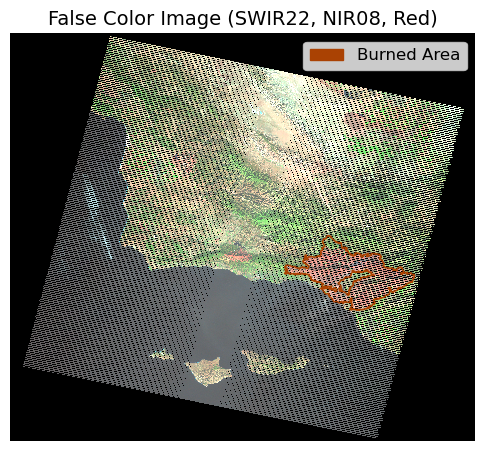

In [18]:
#------------------------------------
# ----  Plot Landsat False Color ----
#------------------------------------
# Adjust the figure size and DPI
fig, ax = plt.subplots(figsize=(6, 6)) 

# Plot false color bands
false_color.plot.imshow(ax=ax, robust=True)

# Plot Thomas Fire burn area
thomas_fire.plot(ax=ax, color='none', edgecolor='#AA4203')

# Add a legend for the burned area
fire_scar = mpatches.Patch(color='#AA4203', label='Burned Area')
ax.legend(handles=[fire_scar], loc='upper right', fontsize=12) 

# Add a title to the plot
ax.set_title('False Color Image (SWIR22, NIR08, Red)', fontsize=14)  

# Remove the plot axes
ax.axis('off')

# Save the figure with tight bounding box and high resolution
plt.savefig('thomas_fire_plot.png')  
plt.show()


### Combining the Visuals

Let's put the most informative visuals together into a single figure to gain a full sense of the extent of damage caused by the Thomas Fire. In the figure on the right, can see a large parcel of Santa Barbara County was exposed to the fire, explaining the uptake in particulate matter observed in December of 2017 in AQI the figure on the left.

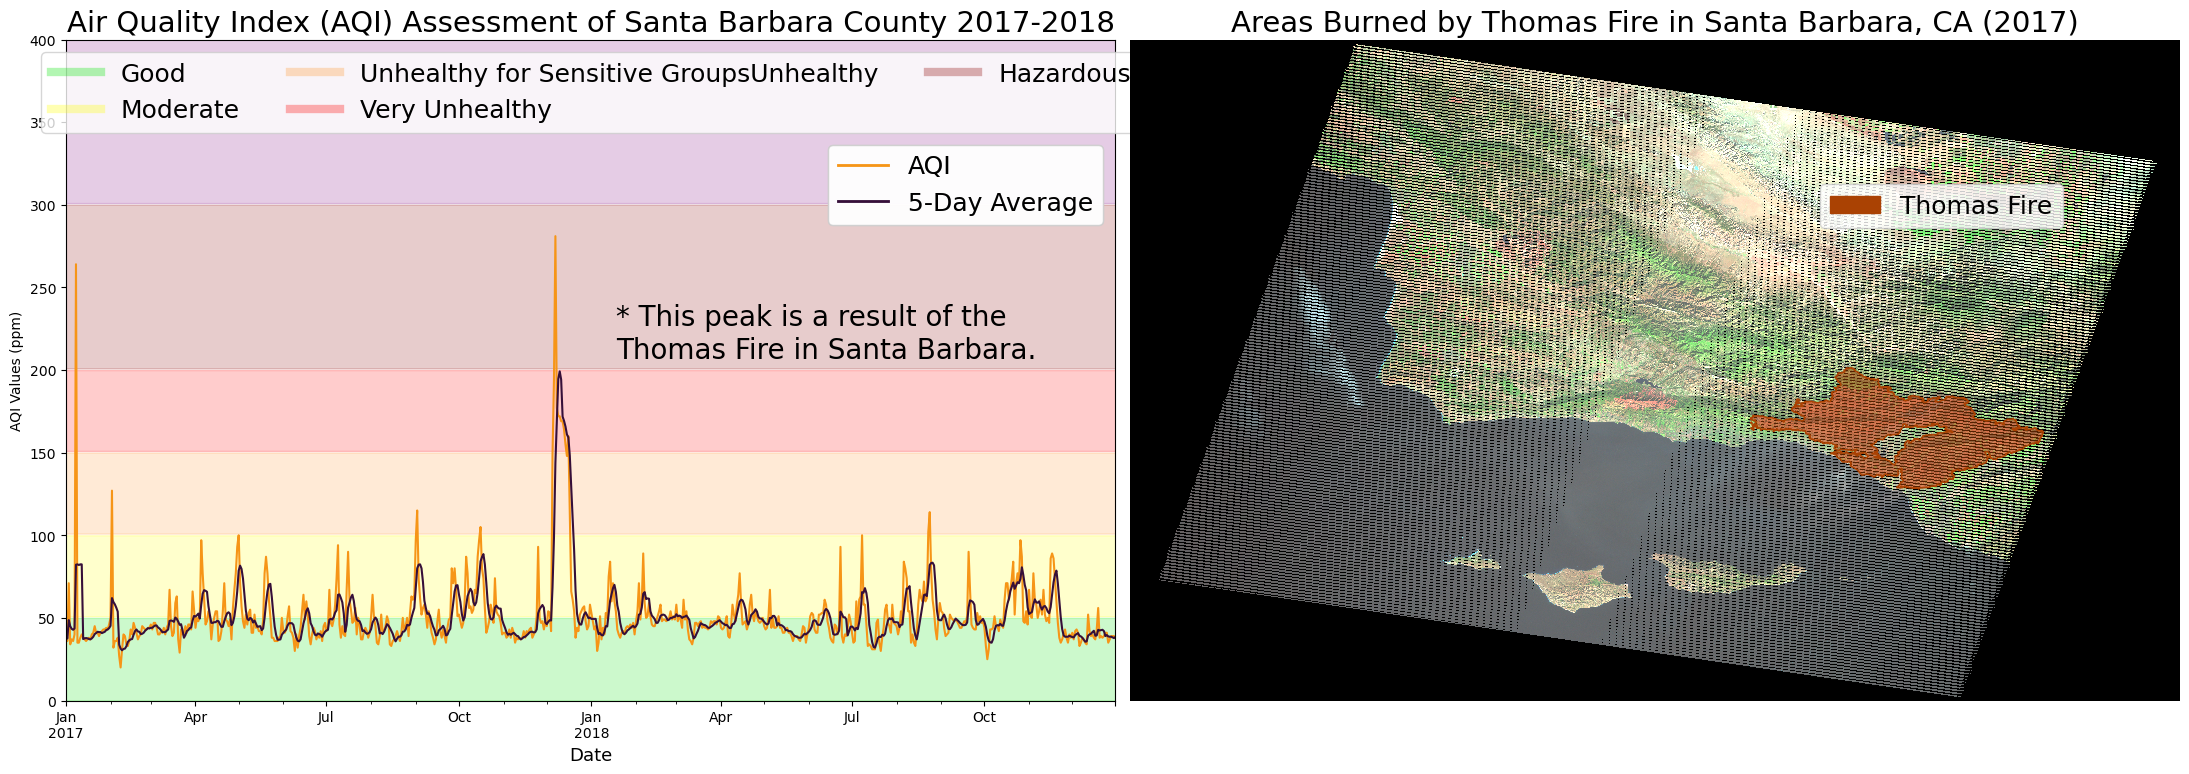

In [19]:
#------------------------------------
#  ----     Customization        ----
#------------------------------------
# Define AQI categories and colors
aqi_categories = {
    'Good': (0, 50, '#00E400'),
    'Moderate': (51, 100, '#FFFF00'),
    'Unhealthy for Sensitive Groups': (101, 150, '#FF9933'),
    'Unhealthy': (151, 200, '#FF0000'),
    'Very Unhealthy': (201, 300, '#8B0000'),
    'Hazardous': (301, 500, '#800080')
}

colors = {'aqi':'#f69517',
          'five_day_average':'#360F39'}

# Plot the images in the same figure side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize = (22,8)) 


#------------------------------------------------------------------------
# Plotting the Daily & 5-Day Rolling Window AQI for Santa Barbara County 
#------------------------------------------------------------------------
#------------------------------------
#  ----     Visualizing AQI      ----
#------------------------------------
# Plot AQI categories as background colors for associated ranges
for category, (lower, upper, color) in aqi_categories.items():
    ax1.fill_between(aqi_sb.index, lower, upper, color=color, alpha=0.2, label=f'{category}')

# Plot the AQI and 5-Day Rolling Average
aqi_sb.plot(ax=ax1,
            y=['aqi', 'five_day_average'],
            color=colors,             
            ylim= (0,400),
            legend= True,
            ylabel='AQI Values (ppm)'
            )

# applying customizations
ax1.set_title('Air Quality Index (AQI) Assessment of Santa Barbara County 2017-2018', 
             fontsize=21) 

ax1.set_xlabel(xlabel='Date',
               fontsize = 13)

ax2.set_ylabel(ylabel='AQI Values (ppm)',
               fontsize = 10)

# Add a legend for background colors
background_legend = [Line2D([0], [0], color='#00E400', lw=6, alpha=0.3),
                     Line2D([0], [0], color='#FFFF00', lw=6, alpha=0.3),
                     Line2D([0], [0], color='#FF9933', lw=6, alpha=0.3),
                     Line2D([0], [0], color='#FF0000', lw=6, alpha=0.3),
                     Line2D([0], [0], color='#8B0000', lw=6, alpha=0.3),
                     Line2D([0], [0], color='#800080', lw=6, alpha=0.3)]

# Add background color legend to the plot
background_legend_art = ax1.legend(handles=background_legend,
                                  labels=['Good', 'Moderate', 
                                          'Unhealthy for Sensitive Groups'
                                          'Unhealthy', 'Very Unhealthy',
                                          'Hazardous'],
                                  loc='upper center',
                                  bbox_to_anchor=(0.5, 1),
                                  ncol=3,
                                  fontsize = 18)
# Line color legend
line_legend = [Line2D([0], [0], color='#f69517', lw=2),
               Line2D([0], [0], color='#360F39', lw=2)]

# Add line color legend to the plot
line_legend_art = ax1.legend(handles=line_legend,
                            labels=['AQI', '5-Day Average'],
                            loc='upper right',
                            bbox_to_anchor=(1, 0.86),
                            fontsize = 18)

# Add both legends to the plot
ax1.add_artist(background_legend_art)
ax1.add_artist(line_legend_art)

# Add annotation
ax1.annotate("* This peak is a result of the \nThomas Fire in Santa Barbara.", 
            xy=(0.28, 0.52), # position
            xycoords='figure fraction', 
            fontsize=20, 
            color='black') 
#------------------------------------------------------------------------
#        Plotting the Thomas Fire burned areas of Santa Barbara
#------------------------------------------------------------------------
 # Remove plot axes
plt.axis('off')                               
# Plot false color bands
false_color.plot.imshow(ax = ax2,              
                        # Include colors
                        robust = True)        

# Plot thomas fire burn area
thomas_fire.plot(ax = ax2,                     
       # No color of burn area
       color = 'none',                         
       # Opacity of edgecolor
       edgecolor = '#AA4203')     
          
# Add a figure legend
fire_scar = mpatches.Patch(color = '#AA4203',
                          label = 'Burned Area') 

ax2.legend(handles=[fire_scar])

#------------------------------------
# ----   Plot the Fire Bound    -----
#------------------------------------
thomas_fire.plot(ax = ax2,
                 color = '#AA4203',
                 # make border around shapefile
                edgecolor = '#AA4203', 
                 # make transparent
                alpha = 0.5)

fire_patch = mpatches.Patch(color = '#AA4203',
                            label = "Thomas Fire")

#------------------------------------
# ----  Plot Landsat False Color ----
#------------------------------------
# Plot the false landsat
false_color.plot.imshow(ax = ax2,
                          robust = True) 

# Edit the Legend and Caption 
# Show lables for legend
ax2.legend(handles = [fire_patch], 
        # No border around legend
          frameon = True,
        # Where legend is located
          bbox_to_anchor = (0.9, 0.8),
          fontsize = 18) 
 
# Add title
ax2.set_title('Areas Burned by Thomas Fire in Santa Barbara, CA (2017)',
               fontsize = 21) 

# Plot the whole figure  
# space well
fig.tight_layout()
plt.show()

#### Citations:

1. Wikipedia contributors. "Thomas Fire." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 16 Apr. 2024. Web. 2 Aug. 2024.

2.  VCFD determines cause of The thomas fire. Ventura County Fire Department. (2019, March 13). https://vcfd.org/news/vcfd-determines-cause-of-the-thomas-fire/ 

3. Wildfire Today. “Thomas Fire Archives - Wildfire Today.” Wildfire Today, 14 Nov. 2019, https://wildfiretoday.com/tag/thomas-fire.

4. California, State Of. Montecito Mudslides Anniversary, Reflections Through Images | Cal OES News. https://news.caloes.ca.gov/montecito-mudslides-anniversary-reflections-through-images.

5. AirNow.gov, U.S. EPA. (n.d.). Aqi Basics. AQI Basics | AirNow.gov. https://www.airnow.gov/aqi/aqi-basics/

6. Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

7. California fire perimeters (all). California State Geoportal. (n.d.). https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about